In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import OrderedDict
from ipywidgets import interact, interact_manual
from src.datasets import physionet2016
from src.display import plots
# Ability to hide code and output is enabled by https://github.com/kirbs-/hide_code
print('pandas version: ' + pd.__version__)
sns.set(style="white", palette="muted", color_codes=True)

# Helpers
def bg_color(max_opacity):
    return lambda x: "background: rgba(0, 0, 255, {})".format(np.abs(x)*max_opacity)

def dist_plot(series):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(5, 1) #, height_ratios=[1, 1, 2]
    axes = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[2, 0]),
        fig.add_subplot(gs[3, 0]),
        fig.add_subplot(gs[4, 0]),
    ]
    for i in range(5):
        values, xlim = series[i]
        sns.distplot(values, bins=100, color="b", kde=False, ax=axes[i])
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        axes[i].annotate('mean: {:3.2f}ms\nstd: {:3.2f}ms'.format(mean, std), xy=(0.8, 0.6), xycoords='axes fraction')
        if xlim:
            axes[i].set_xlim(*xlim)
    plt.tight_layout();
    
def plot_person_stats(data):
    dist_plot([
        (data['S1_mean'], (0,800)),
        (data['systole_mean'], (0,800)),
        (data['S2_mean'], (0,800)),
        (data['diastole_mean'], (0,800)),
        (data['cycle_mean'], (0,1600))
    ])

def pairplot(data):
    g = sns.PairGrid(data, diag_sharey=False)
    g.map_lower(sns.kdeplot, kernel='gau', n_levels=10)#, shade=True, shade_lowest=False)
    #g.map_lower(plt.scatter, marker='.')
    g.map_upper(plt.scatter, marker='.')
    g.map_diag(sns.kdeplot)
    g.fig.set_size_inches(14,14);    

pandas version: 0.20.3


/Users/kmamykin/anaconda3/envs/hearts/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Exploratory study of Cardiac Cycle Durations

## Content

1. Data description, preparation, assumptions
2. Dataset statistics
3. Duration distribution
    * Normalization of conditional per person distributions
    * Normal dist fit
    * Gamma dist fit
    * Log-normal dist fit
4. Classification of recordings based on inferred estimates
5. Kolmogorov-Smirnov tests

## Dataset description

The original dataset comes from a challenge ran by PhysioNet data chellenge 2016 [1]. The dataset consists of 3240 audio recordings of patient's heart sounds (auscultation) and is the largest public collection of phonecardiogram (PCG) recordings. 

All recordings are grouped into several groups ("A"-"E") based on where the recordings were sourced from, representing different contributors of data (research groups).
Each recording has associated metadata that contains a subset and a label for 'normal' and 'abnormal' heart sound classification. For example the recording in Fig.1 came from subset 'f' (first letter in the file id) and labeled as 'abnormal'.

All recordings have been resampled to 2,000 Hz and have been provided as .wav format.

Included annotations indicate the position of two fundamental heart sounds (S1 and S2) and two silent intervals (systole and diastole) between the fundamental sounds. The image below displays one such recording with an audio wave (amplitude of audio samples) with vertical lines indicating the position of the four states under consideration: S1 sound, systole, S2 sound and diastole. Intervals segmented by two consecutive S1 annotations form a Cardiac Cycle aka one heart beat. The duration of the heart beat is also referred in medical literature as *RR interval*.

Recordings were initially annotated by an algorythm, and then some of the recordings were hand-corrected by humans. This introduced several artifacts in data, and important assumption that we are dealing not with ground truth but an estimate that introduced a measurement error in the true location of annotation and therefor interval durations.


<img style="height: 300px;" src="https://physionet.org/challenge/2016/figure1.png">

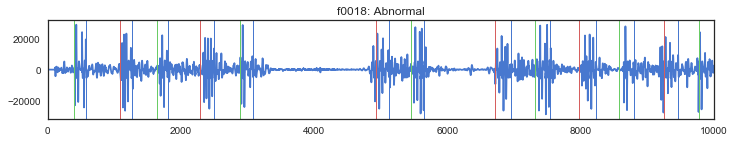

In [2]:
dataset = physionet2016.load_dataset()
plots.plot_recording(dataset.train.select(file_id='f0018').to_list()[0])

## Goals

This paper studies the distribution of the heartbeat cycle durations. Knowing the distribution and being able to estimate parameters of the distribution plays an important role in such tasks as detecting heart
beat in a noisy sensor signal, or building complex models that rely on state transitions/durations such as Hidden Semi-Markov Models. For Baysian methods this study can provide a better informed priors for the distribution of S1/systole/S2/diasole/cycle durations.

Can we say something on the relationship of the systole period relative to the diastole period? (some papers suggested that the systole period is usually no longer than the diastole period). This would help in classification of signal peaks detected in a signal. [ref]

## Data preprocessing

Dataset was preprocessed into three CSV tables: `recordings`, `annotations`, `heartbeats`. `annotations` have been preporcessed into `heartbeats` and not used in this study.

Data has been cleaned by discarding heartbeats with erroneous or inprobably values, such as negative interval durations or abnormally large (>1.5 sec) diastole durations (indicating missing heartbeats in the recording due to noise). Total number of outliers removes is small (27 or 0.0066% of all hearbeats).

In [3]:
recordings = pd.read_csv('../data/recordings.csv', index_col=0).set_index('file_id')
# annotations = pd.read_csv('../data/annotations.csv', index_col=0)
heartbeats = pd.read_csv('../data/heartbeats_msec.csv', index_col=0); 

In [3]:
recordings.head()

,file_path,label,label_code,quality,quality_code,subset
file_id,,,,,,
a0023,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a
a0037,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a
a0221,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a
a0235,/Users/kmamykin/Projects/hearts/data/training/...,normal,-1.0,good,1.0,training-a
a0209,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a


`recordings.csv` represents an audio recording of a patient

In [4]:
heartbeats.head()

,file_id,S1,systole,S2,diastole
0,a0023,140.0,220.0,100.0,820.0
1,a0023,160.0,240.0,100.0,860.0
2,a0023,160.0,240.0,100.0,900.0
3,a0023,140.0,240.0,100.0,880.0
4,a0023,160.0,240.0,100.0,760.0


Some heartbeats miss annotation, resulting in an artificially long diastole interval, thus increasing heartbeat cycle duration. 

In [5]:
heartbeats.describe()

,S1,systole,S2,diastole
count,81508.000000,81508.000000,81508.000000,81508.000000
mean,128.067595,169.804798,102.515968,367.755754
std,17.497264,46.217906,16.275916,142.334345
min,6.000000,20.000000,7.000000,36.500000
25%,120.000000,140.000000,100.000000,260.000000
50%,120.000000,180.000000,100.000000,340.000000
75%,140.000000,200.000000,120.000000,460.000000
max,300.000000,420.000000,439.000000,1480.500000


In [4]:
# Enhance with the calculated column for duration (S1 + systole + S2 + diastole)
heartbeats = heartbeats.pipe(lambda df: df.assign(cycle=df.S1 + df.systole + df.S2 + df.diastole))
STAGES = ['S1', 'systole', 'S2', 'diastole']
METRICS = ['S1', 'systole', 'S2', 'diastole', 'cycle']
heartbeats.head()

,file_id,S1,systole,S2,diastole,cycle
0,a0023,140.0,220.0,100.0,820.0,1280.0
1,a0023,160.0,240.0,100.0,860.0,1360.0
2,a0023,160.0,240.0,100.0,900.0,1400.0
3,a0023,140.0,240.0,100.0,880.0,1360.0
4,a0023,160.0,240.0,100.0,760.0,1260.0


In [6]:
abnormal = recordings['label'] == 'abnormal'
normal = recordings['label'] == 'normal'
subset_a = recordings['subset'] == 'training-a'
subset_b = recordings['subset'] == 'training-b'
subset_c = recordings['subset'] == 'training-c'
subset_d = recordings['subset'] == 'training-d'
subset_e = recordings['subset'] == 'training-e'
subset_f = recordings['subset'] == 'training-f'

counts = heartbeats[['file_id', 'cycle']].groupby('file_id').count()
#counts.sort_values(by='cycle')#plt.hist(counts, bins=5);

/Users/kmamykin/anaconda3/envs/hearts/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


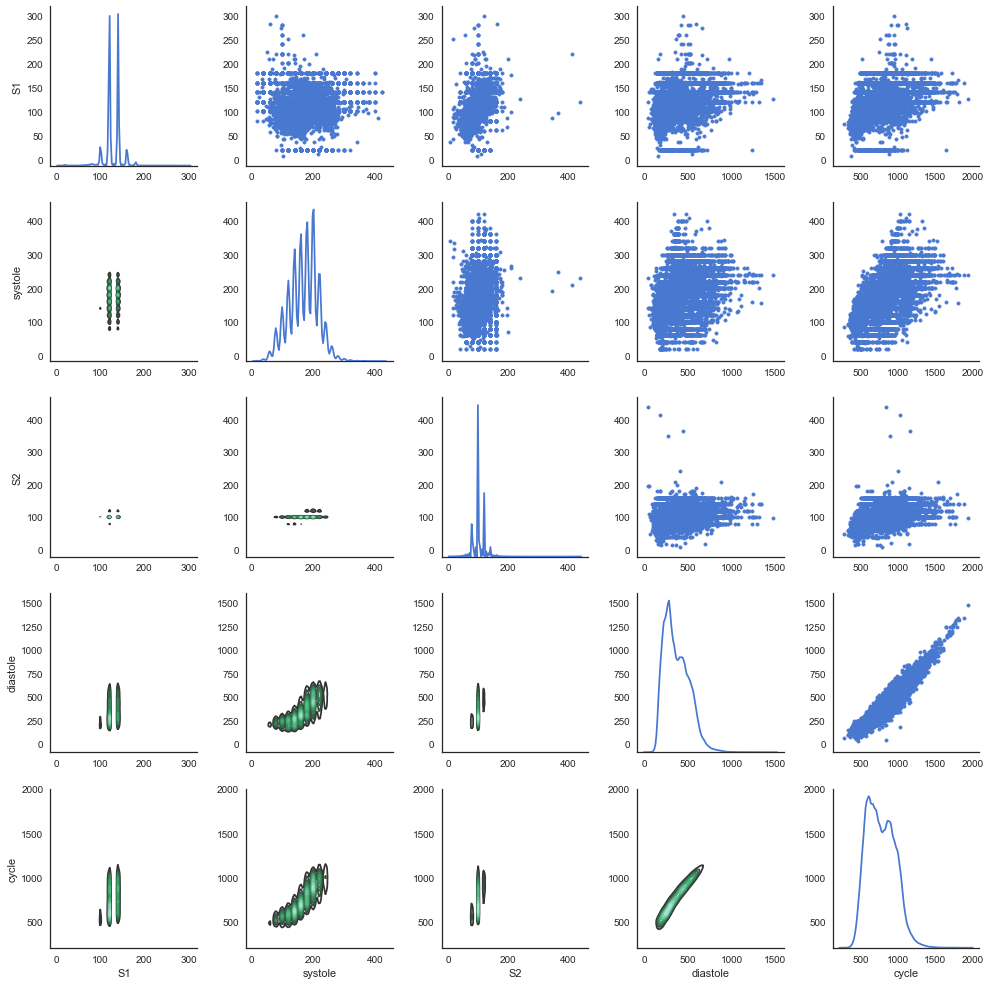

In [25]:
pairplot(heartbeats[METRICS])

In [26]:
heartbeats[METRICS].corr().style.applymap(bg_color(0.7))

,S1,systole,S2,diastole,cycle
S1,1,0.0616718,0.176153,0.204489,0.280418
systole,0.0616718,1,0.333017,0.636799,0.768332
S2,0.176153,0.333017,1,0.377292,0.474065
diastole,0.204489,0.636799,0.377292,1,0.97269
cycle,0.280418,0.768332,0.474065,0.97269,1


## Notes on the un-normalized durations pairplot and correlation matrix

On the pairplot of unnormalized hearbeat metrics several artifacts are noticable that are related to the process how annotations were produced. 

1) S1 and S2 durations exhibit a strong descreet tendency, where only a few values were used to encode annotations. For example S1 durations tend to have values of 100, 120, 140, 160 and S2 durations tend to have values of 80, 100, 125. This is probably attributed to the fact that annotations were produced buy a Hidden Semi-Marlov Model (HSMM) where state stansitions are time dependent, and the model learned to switch states only at certain time intervals. Had the annotations been fully human coded, a more continuous distribution would be produced in the result.

2) S1/S2 density plot (below the diagonal) places most of the probability density on just a few points, also attributed to the descreen tendency of measuruments.

4) On scatterplots (above the diagonal) a grid pattern is noticable in the areas of low probability, where only a few measurements were recorded. Again this is attributed to the descreet resolution of the annotations.

There is a strong correlation between durations of all stages of heartbeats and the duration of the full cycle. This is not surprising given the cycle is the sum of all stages, and the longer an proportion of each stage in the full cycle the higher is the correlation.

(^\/ merge/edit)

Hearbeat has a higher correlation with other metrics (0.31, 0.34, 0.35, 0.73) because it is a sum of all of then, so for a heart cycle, when one metric (e.g. S1) is larger then its mean, the heartbeat will also be higher. Higher correlation of heartbeat and diastole (0.7) is explained by a generally larger proportion of diastole in the whole heartbeat cycle.

### Distribution of un-normalized full cycle durations in dataset

This distribution clearly shows two modes, first at around 600ms, and another at 875ms. This can be explained by the fact that the dataset is assembled from several smaller subsets, each subset possibly having a biased sampling of patients, e.g. children, who have faster heart rate.


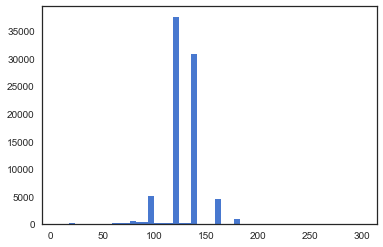

In [25]:
plt.hist(heartbeats['S1'], bins=50);


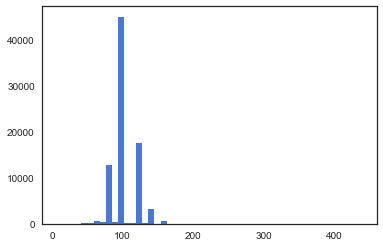

In [26]:
plt.hist(heartbeats['S2'], bins=50);


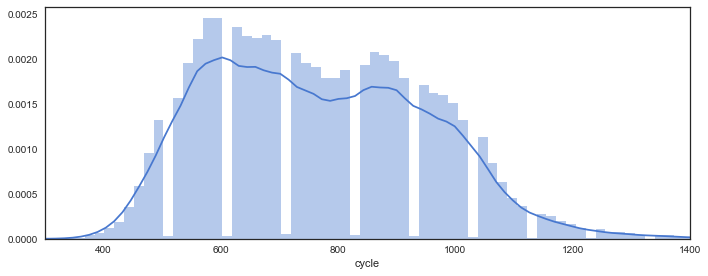

In [33]:
f, axes = plt.subplots(1, 1, figsize=(10, 4))
sns.distplot(heartbeats['cycle'], bins=100, color="b", kde=True, ax=axes)
axes.set_xlim(300,1400)
plt.tight_layout();

## Systole vs diastole durations

80748
760
0.009324238111596408


(array([ 130.,   27.,   11.,    2.,    4.,    0.,    3.,    0.,    1.,    1.]),
 array([  1. ,   4.9,   8.8,  12.7,  16.6,  20.5,  24.4,  28.3,  32.2,
         36.1,  40. ]),
 <a list of 10 Patch objects>)

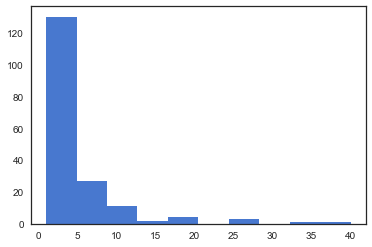

In [7]:
lt = heartbeats['systole'] < heartbeats['diastole']
print(np.count_nonzero(lt))
print(np.count_nonzero(~lt))
print(np.count_nonzero(~lt)/np.size(lt))
gt_counts = heartbeats[~lt].groupby('file_id')['cycle'].count()
plt.hist(gt_counts)


## Modelling assumptions

We assume that the underlying data comes from a two level hierarchical model. 

First, from the population of all people, the patients in this dataset (~3240) were sampled and their heart sounds were recorded. The selection of patients in the dataset is not totally independent, and probably reflects biases in the research groups that provided the data (e.g. normal vs abnormal bias, age group, recording condition). This potential difference in distributions from different subsets can be analysed further. For this project we assume that we have a random sample of people with recordings made in similar conditions (patients at rest). This sample is further referred to as "people sample".

Second, for each person, a series of heartbeats were recorded. The number of heartbeats recorded in the dataset ranges from 3 to 173 per person. Since the recordings were taken over a short period of time we assume that the underlying distribution parameters did not change during the recording (e.g. heart rate stayed consistent and did not drift). This is referred to as "heartbeat sample" and can be analysed conditional on a person, or pooled together after standartization.

## People stats

When exploring people's statistics we look at the aggregated summaries of person's heartbeats, such as mean/std/var of each interval duration.

In [8]:
def stats_summary(df, groupby, stats):
    groups = df.groupby(groupby).agg(stats)
    groups.columns = ['_'.join(col).strip() for col in groups.columns.values]
    return groups

person_stats = stats_summary(heartbeats, 'file_id', ['mean', 'std', 'var', 'count'])
person_stats = pd.merge(person_stats, recordings, left_index=True, right_index=True)
person_stats.head()

,S1_mean,S1_std,S1_var,S1_count,systole_mean,systole_std,systole_var,systole_count,S2_mean,S2_std,...,cycle_mean,cycle_std,cycle_var,cycle_count,file_path,label,label_code,quality,quality_code,subset
file_id,,,,,,,,,,,,,,,,,,,,,
a0001,130.555556,12.175959,148.253968,36,238.888889,11.656458,135.873016,36,107.222222,9.742722,...,975.000000,34.928498,1220.000000,36,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a
a0002,140.769231,15.728465,247.384615,26,126.538462,24.115109,581.538462,26,124.038462,10.956207,...,769.230769,21.339743,455.384615,26,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a
a0003,137.500000,10.733936,115.217391,24,177.500000,15.948286,254.347826,24,143.333333,9.630868,...,1215.000000,42.220951,1782.608696,24,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a
a0004,133.529412,10.697593,114.438503,34,214.117647,10.478737,109.803922,34,105.882353,10.478737,...,1001.764706,59.770804,3572.549020,34,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a
a0005,124.230769,10.727672,115.082956,52,125.384615,11.282737,127.300151,52,98.846154,12.151631,...,676.153846,47.368139,2243.740573,52,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a


### Per-person mean distribution

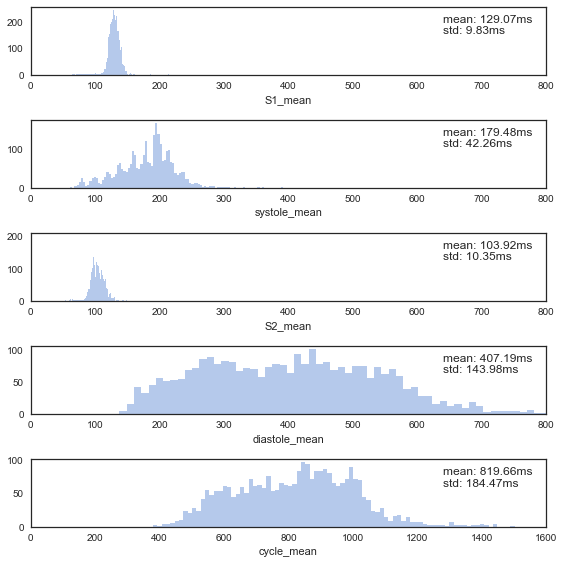

In [321]:
dist_plot([
    (person_stats['S1_mean'], (0,800)),
    (person_stats['systole_mean'], (0,800)),
    (person_stats['S2_mean'], (0,800)),
    (person_stats['diastole_mean'], (0,800)),
    (person_stats['cycle_mean'], (0,1600))
])


/Users/kmamykin/anaconda3/envs/hearts/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


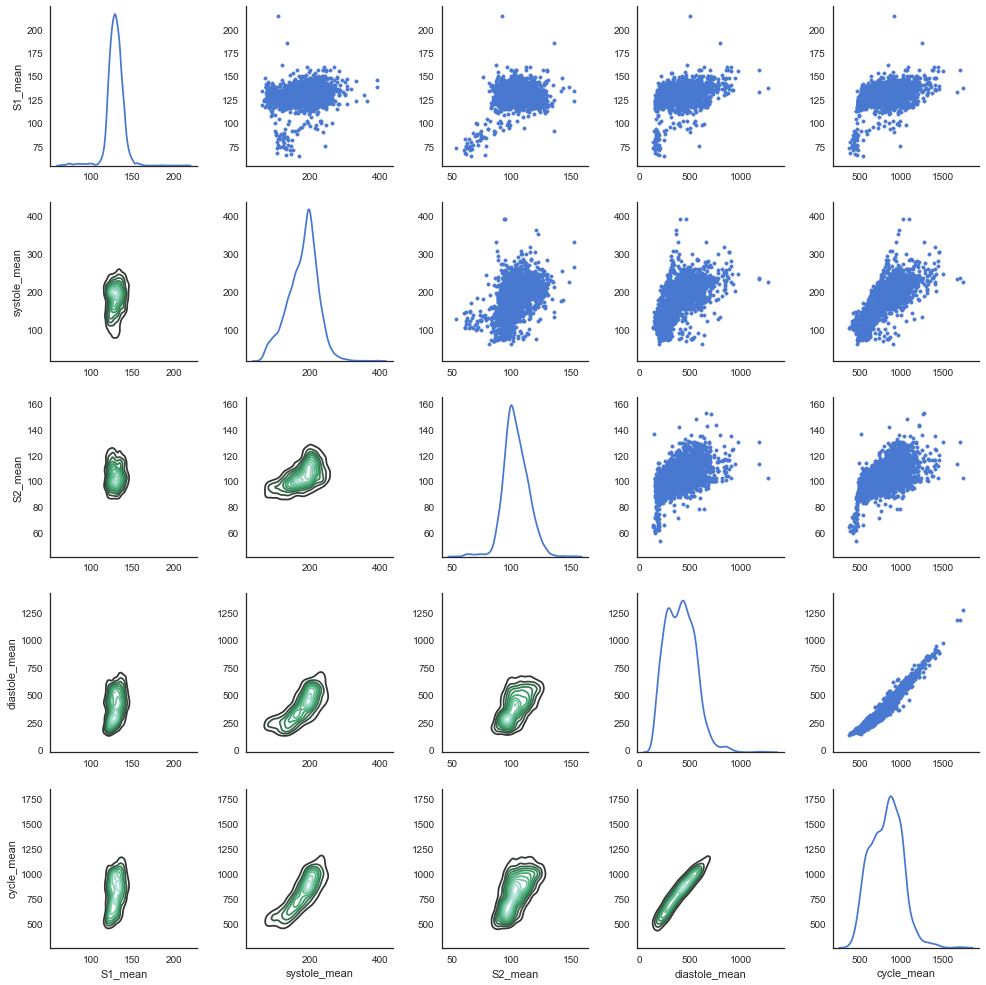

In [349]:
pairplot(person_stats[['S1_mean', 'systole_mean', 'S2_mean', 'diastole_mean', 'cycle_mean']])

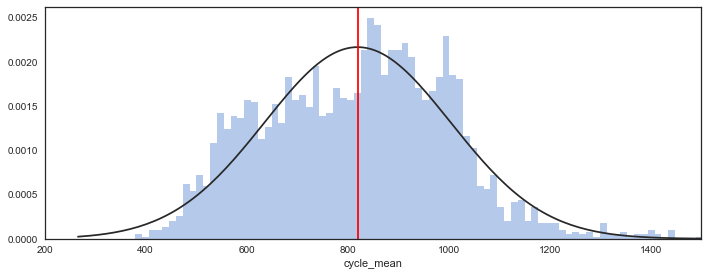

In [108]:
f, axes = plt.subplots(1, 1, figsize=(10, 4))
sns.distplot(person_stats['cycle_mean'], bins=100, color="b", kde=False, ax=axes, fit=stats.norm)
axes.set_xlim(200,1500)
axes.axvline(x=person_stats['cycle_mean'].mean(), color='red')
plt.tight_layout();


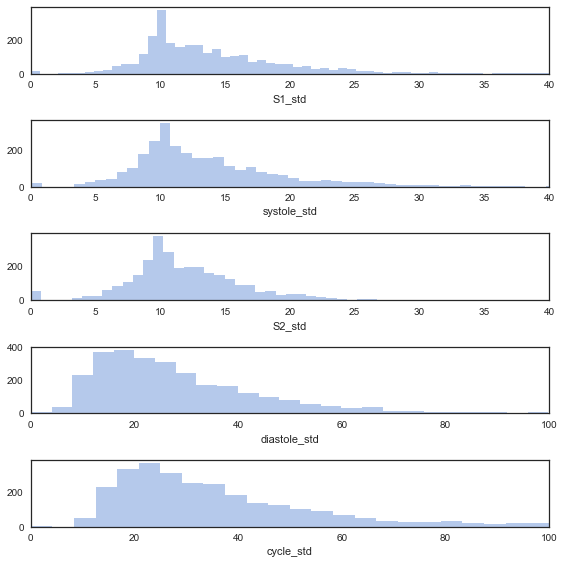

In [38]:
dist_plot([
    (person_stats['S1_std'], (0,40)),
    (person_stats['systole_std'], (0,40)),
    (person_stats['S2_std'], (0,40)),
    (person_stats['diastole_std'], (0,100)),
    (person_stats['cycle_std'], (0,100))
])


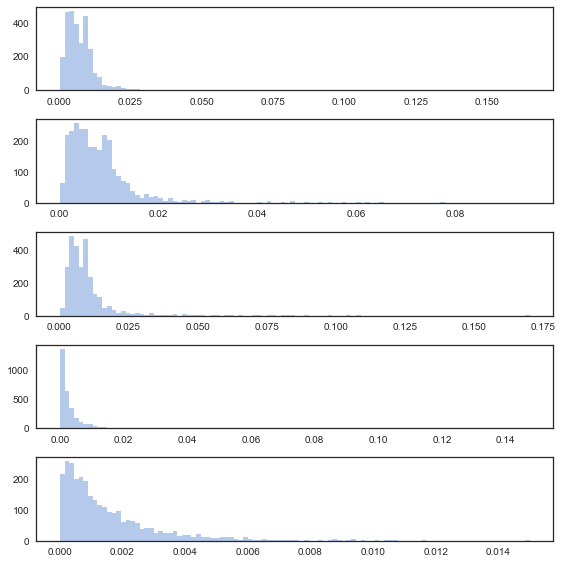

In [53]:
def precision(var):
    nz = var.values[np.nonzero(var.values)]
    return 1.0/nz

dist_plot([
    (precision(person_stats['S1_var']), None),
    (precision(person_stats['systole_var']), None),
    (precision(person_stats['S2_var']), None),
    (precision(person_stats['diastole_var']), None),
    (precision(person_stats['cycle_var']), None)
])


In [ ]:
plot_person_stats(person_stats.loc[normal, :])

In [ ]:
plot_person_stats(person_stats.loc[abnormal, :])

In [ ]:
def distplot(series, xlim):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(len(series), 1) #, height_ratios=[1, 1, 2]
    axes = [fig.add_subplot(gs[i, 0]) for i in range(len(series))]
    for i in range(len(series)):
        values = series[i]
        sns.distplot(values, bins=50, color="b", kde=False, ax=axes[i])
        axes[i].set_xlim(*xlim)
    plt.tight_layout();
    
distplot([
    person_stats.loc[subset_a, ['cycle_mean']],
    person_stats.loc[subset_b, ['cycle_mean']],
    person_stats.loc[subset_c, ['cycle_mean']],
    person_stats.loc[subset_d, ['cycle_mean']],
    person_stats.loc[subset_e, ['cycle_mean']],
    person_stats.loc[subset_f, ['cycle_mean']],
], (0, 1500))    

### Normalized heartbeat durations (normalization per person)


In [9]:
joined = pd.merge(heartbeats, person_stats, left_on='file_id', right_index=True)
joined.head()

,file_id,S1,systole,S2,diastole,cycle,S1_mean,S1_std,S1_var,S1_count,...,cycle_mean,cycle_std,cycle_var,cycle_count,file_path,label,label_code,quality,quality_code,subset
0,a0023,140.0,220.0,100.0,820.0,1280.0,142.727273,14.203225,201.731602,22,...,1301.818182,74.042225,5482.251082,22,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a
1,a0023,160.0,240.0,100.0,860.0,1360.0,142.727273,14.203225,201.731602,22,...,1301.818182,74.042225,5482.251082,22,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a
2,a0023,160.0,240.0,100.0,900.0,1400.0,142.727273,14.203225,201.731602,22,...,1301.818182,74.042225,5482.251082,22,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a
3,a0023,140.0,240.0,100.0,880.0,1360.0,142.727273,14.203225,201.731602,22,...,1301.818182,74.042225,5482.251082,22,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a
4,a0023,160.0,240.0,100.0,760.0,1260.0,142.727273,14.203225,201.731602,22,...,1301.818182,74.042225,5482.251082,22,/Users/kmamykin/Projects/hearts/data/training/...,abnormal,1.0,good,1.0,training-a


In [10]:
def normalized_metric(df, metric):
    return (df[metric] - df[metric+'_mean'])/(df[metric+'_std']+1e-10)

normalized_heartbeats = pd.DataFrame({
    'S1': normalized_metric(joined, 'S1'),
    'systole': normalized_metric(joined, 'systole'),
    'S2': normalized_metric(joined, 'S2'),
    'diastole': normalized_metric(joined, 'diastole'),
    'cycle': normalized_metric(joined, 'cycle')
})

/Users/kmamykin/anaconda3/envs/hearts/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


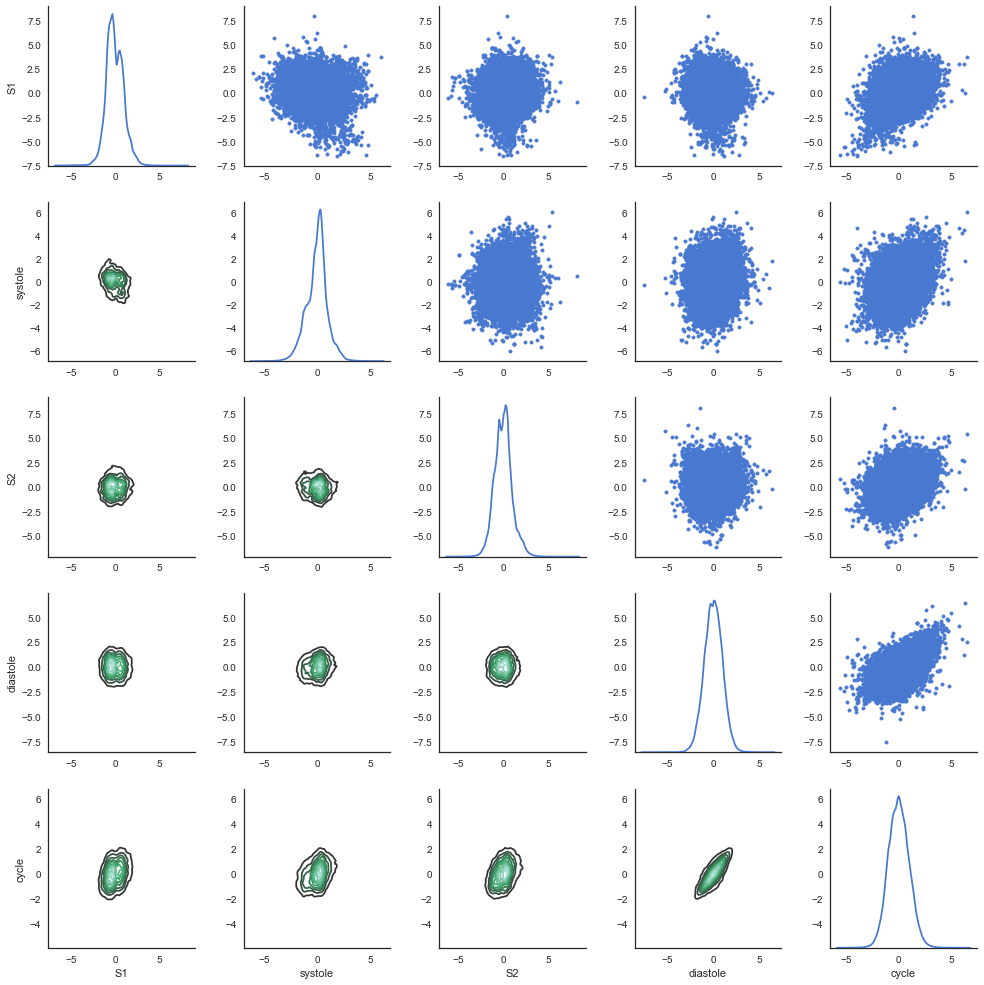

In [37]:
pairplot(normalized_heartbeats[METRICS]);

In [40]:
normalized_heartbeats[METRICS].corr().style.applymap(bg_color(0.7))

,S1,systole,S2,diastole,cycle
S1,1,-0.247248,0.0740319,-0.0365555,0.315934
systole,-0.247248,1,-0.0696271,0.153038,0.345362
S2,0.0740319,-0.0696271,1,0.0154435,0.351359
diastole,-0.0365555,0.153038,0.0154435,1,0.733043
cycle,0.315934,0.345362,0.351359,0.733043,1


In [266]:
normalized_heartbeats['cycle'].describe()

count    8.150800e+04
mean     8.786927e-18
std      9.821177e-01
min     -5.569866e+00
25%     -6.710616e-01
50%     -2.031537e-02
75%      6.466112e-01
max      6.461619e+00
Name: cycle, dtype: float64

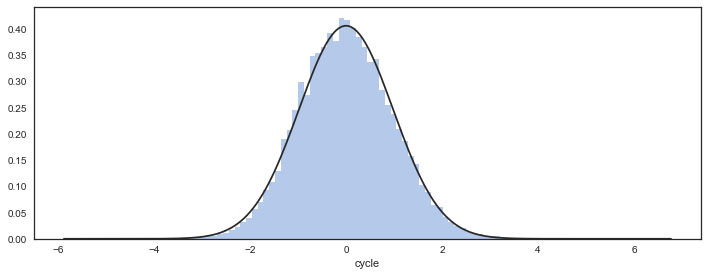

In [265]:
f, axes = plt.subplots(1, 1, figsize=(10, 4))
sns.distplot(normalized_heartbeats['cycle'], bins=100, color="b", kde=False, ax=axes, fit=stats.norm)
# axes.set_xlim(-4,4)
plt.tight_layout();

In [283]:
normalized_cycles_clipped = np.clip(normalized_heartbeats['cycle'].values, -3, 3)
stats.shapiro(np.random.choice(normalized_cycles_clipped, 5000))

(0.9992608428001404, 0.03419826924800873)

In [293]:
stats.shapiro(stats.norm.rvs(size=5000))

(0.9996888637542725, 0.6729294657707214)

In [274]:
stats.anderson(normalized_heartbeats['cycle'].values, dist='norm')

AndersonResult(statistic=17.156942948597134, critical_values=array([ 0.576,  0.656,  0.787,  0.918,  1.092]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

In [275]:
stats.anderson(normalized_cycles_clipped, dist='norm')

AndersonResult(statistic=15.248998925919295, critical_values=array([ 0.576,  0.656,  0.787,  0.918,  1.092]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

In [311]:
stats.kstest(normalized_heartbeats['cycle'].values, 'norm')

KstestResult(statistic=0.013164388972106145, pvalue=1.076064222012886e-12)

In [277]:
stats.kstest(normalized_cycles_clipped,'norm')

KstestResult(statistic=0.013164388972106145, pvalue=1.076064222012886e-12)

In [329]:
def kstest_vs_n(data, num=100, trials=10, n_min=10, n_max=20000):
    n_samples = np.linspace(n_min, n_max, num=num, dtype=np.int)
    kstest = np.zeros((len(n_samples), 2, trials))
    for i, n in enumerate(n_samples):
        kk = np.zeros(())
        for t in range(trials):
            rand_sample = np.random.choice(data, n)
            result = stats.kstest(rand_sample, 'norm')
            kstest[i,0,t] = result.statistic
            kstest[i,1,t] = result.pvalue
    return n_samples, kstest

def plot_kstest_vs_n(n_samples, data):
    #plt.plot(n_samples, np.average(data, axis=2)[:,0], label='statistic');
    plt.plot(n_samples, np.average(data, axis=2)[:,1], label='p-value');
    plt.legend()
    
# sample = stats.norm.rvs(size=80000)
# sample = normalized_heartbeats['cycle'].values
# n_samples, kstest = kstest_vs_n(sample, n_max=20000, num=100, trials=100)
# plt.plot(n_samples, np.average(kstest, axis=2)[:,0], label='statistic');
# plt.plot(n_samples, np.average(kstest, axis=2)[:,1], label='p-value');
# plt.legend()


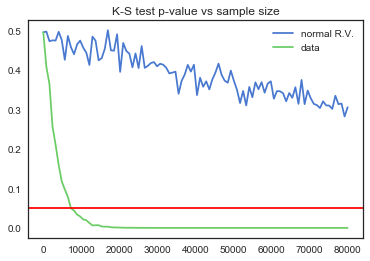

In [336]:
n_samples, norm_kstest = kstest_vs_n(stats.norm.rvs(size=80000), n_max=80000, num=100, trials=100)
n_samples, data_kstest = kstest_vs_n(normalized_heartbeats['cycle'].values, n_max=80000, num=100, trials=100)
plt.title('K-S test p-value vs sample size')
plt.plot(n_samples, np.average(norm_kstest, axis=2)[:,1], label='normal R.V.');
plt.plot(n_samples, np.average(data_kstest, axis=2)[:,1], label='data');
plt.axhline(0.05, color='red')
plt.legend()


In [479]:
print('normal skewtest teststat = %6.3f pvalue = %6.4f' % stats.skewtest(normalized_heartbeats['cycle'].values))
print('normal kurtosistest teststat = %6.3f pvalue = %6.4f' % stats.kurtosistest(normalized_heartbeats['cycle'].values))
print('normaltest teststat = %6.3f pvalue = %6.4f' % stats.normaltest(normalized_heartbeats['cycle'].values))

normal skewtest teststat = 12.110 pvalue = 0.0000
normal kurtosistest teststat = 18.628 pvalue = 0.0000
normaltest teststat = 493.648 pvalue = 0.0000


In [193]:
v=person_stats['cycle_mean'].values
norm_means=(v-np.mean(v))/np.std(v)
stats.kstest(norm_means, 'norm')

KstestResult(statistic=0.034174603895546579, pvalue=0.0024354429540171876)

In [235]:
stats.kstest(stats.norm.rvs(size=100000), 'norm')

KstestResult(statistic=0.0032014309797210316, pvalue=0.25696339255614209)

Point to make: sum of 4 slightly dependent R.V. tends to be normally distributed?


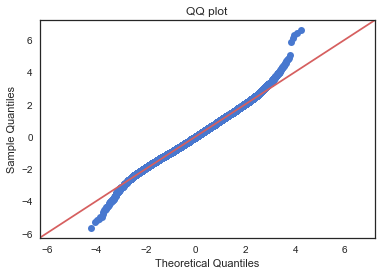

In [337]:
probplot = sm.ProbPlot(normalized_heartbeats['cycle'], stats.norm, fit=True)
probplot.qqplot(line='45')
plt.title('QQ plot')
plt.show()

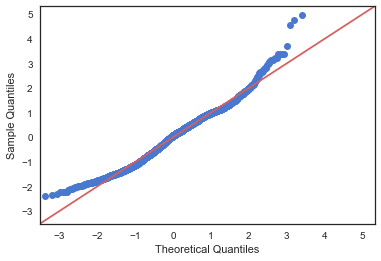

In [196]:
probplot = sm.ProbPlot(person_stats['cycle_mean'], stats.norm, fit=True)
probplot.qqplot(line='45')
plt.show()

In [310]:
def kstest(data):
    result = stats.kstest(data, 'norm')
    return result.statistic, result.pvalue

def shapiro(data):
    return stats.shapiro(data)

def group_normality_test(metric, test):
    def group_fn(g):
        values = g[metric].values
        mean = np.mean(values)
        var = np.var(values, ddof=1)
        norm_values=(values-mean)/(np.sqrt(var)+1e-10)
        statistic, pvalue = test(norm_values)
        return pd.DataFrame({
            'statistic' : [statistic],
            'pvalue': [pvalue],
            'n_heartbeats': [len(values)]
        })
    return group_fn

def print_rejection_counts(df, alpha):
    rejected = df['pvalue'] < alpha
    print('Alpha: {}, rejected normality: {}, not rejected: {}, {}%'.format(
        alpha, np.count_nonzero(rejected), np.count_nonzero(~rejected), 100.*np.count_nonzero(rejected)/len(rejected)))
    
hearbeats_cycle_kstest = (heartbeats.groupby('file_id')
                          .apply(group_normality_test('cycle', kstest)))
print_rejection_counts(hearbeats_cycle_kstest, 0.01)
print_rejection_counts(hearbeats_cycle_kstest, 0.05)
print_rejection_counts(hearbeats_cycle_kstest, 0.1)


Alpha: 0.01, rejected normality: 261, not rejected: 2612, 9.084580577793247%
Alpha: 0.05, rejected normality: 564, not rejected: 2309, 19.631047685346328%
Alpha: 0.1, rejected normality: 818, not rejected: 2055, 28.471980508179602%


In [58]:
# Var(X1+X2+...+Xn)=SUM(COV(Xi, Xj)) - sum of elements in covariance matrix
print('SUM(Cov({S1, sistole, S2, diastole})) =', np.sum(heartbeats[STAGES].cov().values))
print('Var(S1+sistole+S2+diastole) =', heartbeats['cycle'].agg('var'))

SUM(Cov({S1, sistole, S2, diastole})) = 34812.17353
Var(S1+sistole+S2+diastole) = 34812.17352996638


In [84]:
# Use mean and std for each duration measure to use as the values for "normalization"
ds_stats = heartbeats[METRICS].agg(['mean', 'std', 'var']); ds_stats

,S1,systole,S2,diastole,cycle
mean,128.067595,169.804798,102.515968,367.755754,768.144115
std,17.497264,46.217906,16.275916,142.334345,186.580207
var,306.154230,2136.094832,264.905437,20259.065774,34812.173530


In [83]:
heartbeats['cycle'].var()

34812.17352996638

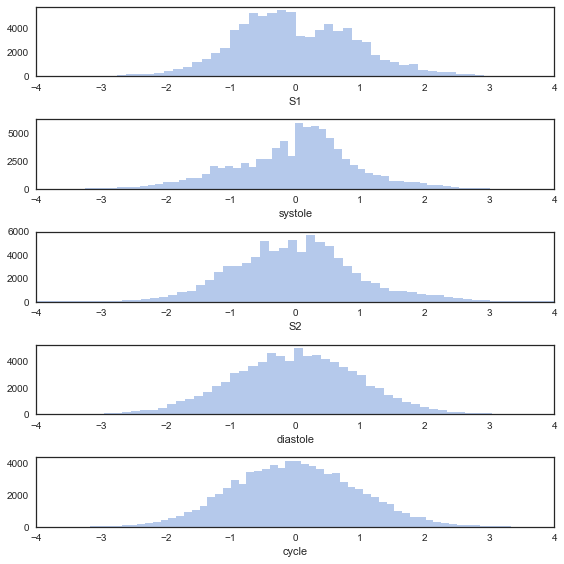

In [59]:
dist_plot([
    (normalized_heartbeats['S1'], (-4,4)),
    (normalized_heartbeats['systole'], (-4,4)),
    (normalized_heartbeats['S2'], (-4,4)),
    (normalized_heartbeats['diastole'], (-4,4)),
    (normalized_heartbeats['cycle'], (-4,4))
])


## Renormalized distribution of hearbeat cycle 

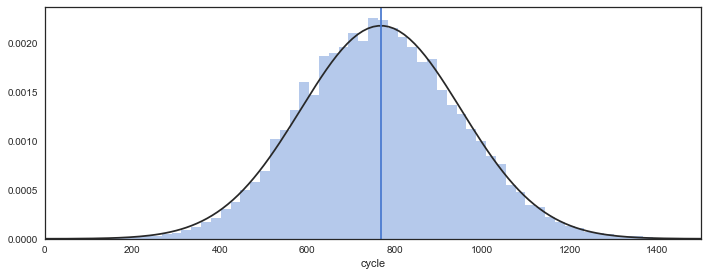

In [64]:
renormalized_heartbeat_durations = normalized_heartbeats.loc[:,'cycle']*ds_stats.loc['std', 'cycle'] + ds_stats.loc['mean', 'cycle']
f, axes = plt.subplots(1, 1, figsize=(10, 4))
sns.distplot(renormalized_heartbeat_durations, bins=100, color="b", kde=False, ax=axes, fit=stats.norm)
axes.set_xlim(0,1500)
axes.axvline(x=ds_stats.loc['mean', 'cycle'])
plt.tight_layout();

In [80]:
renormalized_heartbeat_durations.describe()

count    81508.000000
mean       768.144115
std        183.243725
min       -271.082619
25%        642.937303
50%        764.353670
75%        888.788961
max       1973.754278
Name: cycle, dtype: float64

(array([  1.20000000e+01,   8.40000000e+01,   1.45800000e+03,
          1.64280000e+04,   3.75610000e+04,   2.21130000e+04,
          3.58100000e+03,   2.46000000e+02,   2.00000000e+01,
          5.00000000e+00]),
 array([ -271.08261856,   -46.5989289 ,   177.88476075,   402.3684504 ,
          626.85214005,   851.33582971,  1075.81951936,  1300.30320901,
         1524.78689866,  1749.27058832,  1973.75427797]),
 <a list of 10 Patch objects>)

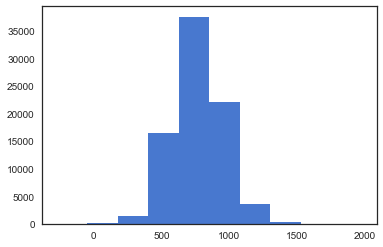

In [81]:
plt.hist(renormalized_heartbeat_durations)

In [82]:
renormalized_heartbeat_durations.sort_values()

21699    -271.082619
76966    -206.873382
70525    -178.424019
71116    -165.484163
37074    -151.302985
40371    -144.870930
2059     -110.587782
72476     -88.019404
17571     -69.964988
28819     -64.718373
24113     -57.198351
23959     -55.412886
26831     -38.520952
7431      -36.242702
71339     -31.154077
67729     -27.393634
44389     -24.151211
7064      -15.737640
4114        1.388855
24901       8.170919
17972      12.699223
74700      19.747461
69048      23.836347
47646      24.679069
64171      27.000232
30109      32.018299
17537      34.066037
17653      34.066037
80593      40.256336
56338      40.439006
            ...     
31320    1505.380034
33410    1507.534775
54513    1514.386259
32995    1518.412492
81063    1520.001262
43803    1528.249857
50399    1529.461130
7069     1539.386983
63118    1544.500320
17942    1550.569182
7346     1551.893350
64300    1561.574092
37043    1569.807042
59002    1572.742386
60798    1573.840053
54046    1581.002925
10084    1595

18.29861861980095 0 4.22129852597
77.243931807
19.2578418335 0 1409.69033083


/Users/kmamykin/anaconda3/envs/hearts/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2303: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


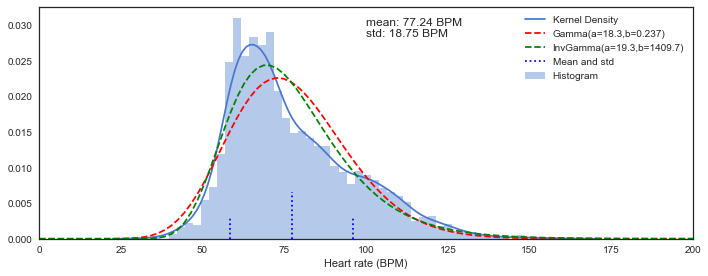

In [509]:
values = 60000/person_stats['cycle_mean']
mean, std = values.mean(), values.std(ddof=1)
gamma_a, gamma_loc, gamma_scale = stats.gamma.fit(values, floc=0)
print(gamma_a, gamma_loc, gamma_scale)
fitted_gamma = stats.gamma(gamma_a, loc=gamma_loc, scale=gamma_scale)
x = np.linspace(0, 200, 100)
print(gamma_loc + gamma_a*gamma_scale)

invgamma_a, invgamma_loc, invgamma_scale = stats.invgamma.fit(values, floc=0)
print(invgamma_a, invgamma_loc, invgamma_scale)
fitted_invgamma = stats.invgamma(invgamma_a, loc=invgamma_loc, scale=invgamma_scale)

f, axes = plt.subplots(1, 1, figsize=(10, 4))
sns.distplot(values, bins=50, kde=True, ax=axes, 
             hist_kws={"label": "Histogram"},
             kde_kws={"label": "Kernel Density"})
axes.plot(x, fitted_gamma.pdf(x), color='red', linestyle='--', label='Gamma(a={:3.3},b={:3.3})'.format(gamma_a, 1/gamma_scale))
axes.plot(x, fitted_invgamma.pdf(x), color='green', linestyle='--', label='InvGamma(a={:3.3},b={:3.5})'.format(invgamma_a, invgamma_scale))

axes.annotate('mean: {:3.2f} BPM\nstd: {:3.2f} BPM'.format(mean, std), xy=(0.50, 0.87), xycoords='axes fraction')
axes.axvline(x=mean, ymin=0, ymax=0.2, color='blue', linestyle=':', label='Mean and std')
axes.axvline(x=mean-std, ymin=0, ymax=0.1, color='blue', linestyle=':')
axes.axvline(x=mean+std, ymin=0, ymax=0.1, color='blue', linestyle=':')
axes.set_xlim(0,200)
axes.set_xlabel('Heart rate (BPM)')
axes.legend()
plt.tight_layout()

In [446]:
print('Sample mean {:3.3}'.format(mean))
print('Sample std {:3.3}'.format(std))
print('Sample size', len(values))
df = len(values)-1
print('Degrees of freedom', df)
confidence_level = 0.95
print('Confidence level', confidence_level)
tail_prob = (1-confidence_level)/2 # 2 sided
critical_value = stats.t.ppf(1-tail_prob, 2872)
print('Critical value t.ppf({}, {}) = {:.5}'.format(1-tail_prob, df, critical_value))
std_hat = std/np.sqrt(len(values))
print('Sampling distribution std estimate {:.2}'.format(std_hat))
me = critical_value * std_hat
print('Margin of error {:.2}'.format(me))
print('{}% confidence interval for the mean ({:.4}, {:.4})'.format(confidence_level*100, mean-me, mean+me))

Sample mean 77.2
Sample std 18.8
Sample size 2873
Degrees of freedom 2872
Confidence level 0.95
Critical value t.ppf(0.975, 2872) = 1.9608
Sampling distribution std estimate 0.35
Margin of error 0.69
95.0% confidence interval (76.56, 77.93)


In [149]:

def plot_rv(rv):
    x = np.linspace(0, rv.ppf(0.990), 100)
    plt.axvline(x=rv.mean(), color='red')
    plt.axvline(x=rv.mean()-rv.std(), color='blue')
    plt.axvline(x=rv.mean()+rv.std(), color='blue')
    plt.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='gamma pdf')
    
@interact(a=(0,100,1.0), mean=(1.0,2500.0))
def plot_gamma(a, mean):
    scale = mean/a
    rv = stats.gamma(a, loc=0, scale=scale)
    plot_rv(rv)


A Jupyter Widget

In [114]:
heartbeats.groupby('file_id')['duration'].count().sort_values(ascending=False).head()

file_id
e01899    173
e01355    167
e01010    162
c0024     142
c0031     134
Name: duration, dtype: int64

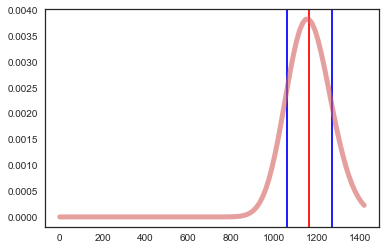

In [134]:
# heartbeats.query('file_id == "e01899"')
vals = heartbeats.loc[heartbeats['file_id'] == "e01899", 'duration'].values
a, loc, scale = stats.gamma.fit(vals, loc=0)
rv = stats.gamma(a, loc=loc, scale=scale)
plot_rv(rv, loc)


## Paired difference test on the relative duration of systole and diastole

In [429]:
differences = person_stats['systole_mean'] - person_stats['diastole_mean']
# plt.hist(differences, bins=100);
differences.describe()
print(differences.sort_values())

file_id
e01867   -1042.500000
e02030    -948.888889
e00152    -940.000000
d0012     -748.000000
b0311     -725.000000
b0114     -700.000000
b0464     -675.000000
f0067     -663.886364
d0004     -661.500000
e01299    -661.250000
a0220     -644.137931
b0200     -640.000000
b0010     -640.000000
b0101     -640.000000
b0123     -632.000000
e00703    -631.111111
a0288     -629.629630
a0338     -628.461538
b0070     -628.000000
d0016     -627.500000
a0344     -627.200000
a0286     -622.288462
d0038     -620.000000
a0305     -618.333333
a0362     -606.923077
a0292     -604.444444
b0202     -596.000000
b0477     -592.000000
a0233     -591.854839
b0085     -588.000000
             ...     
e02097     -29.375000
c0009      -29.134409
e00150     -29.090909
a0280      -28.771930
e00029     -28.196721
e00176     -27.826087
e00525     -27.111111
f0029      -27.037037
e01803     -26.976190
e00829     -26.285714
e01521     -25.555556
e01515     -25.333333
e00210     -24.800000
e01172     -24.489796
e0

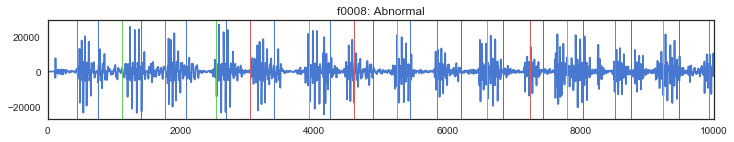

In [432]:
dataset = physionet2016.load_dataset()
plots.plot_recording(dataset.train.select(file_id='f0008').to_list()[0])

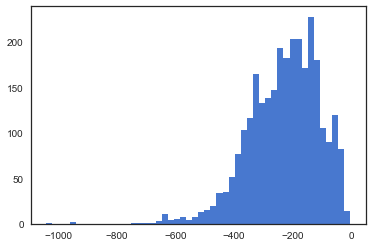

In [433]:
plt.hist(differences, bins=50);

In [351]:
stats.ttest_rel(person_stats['systole_mean'], person_stats['diastole_mean'])

Ttest_relResult(statistic=-101.07875686086901, pvalue=0.0)

## Interval proportions

/Users/kmamykin/anaconda3/envs/hearts/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


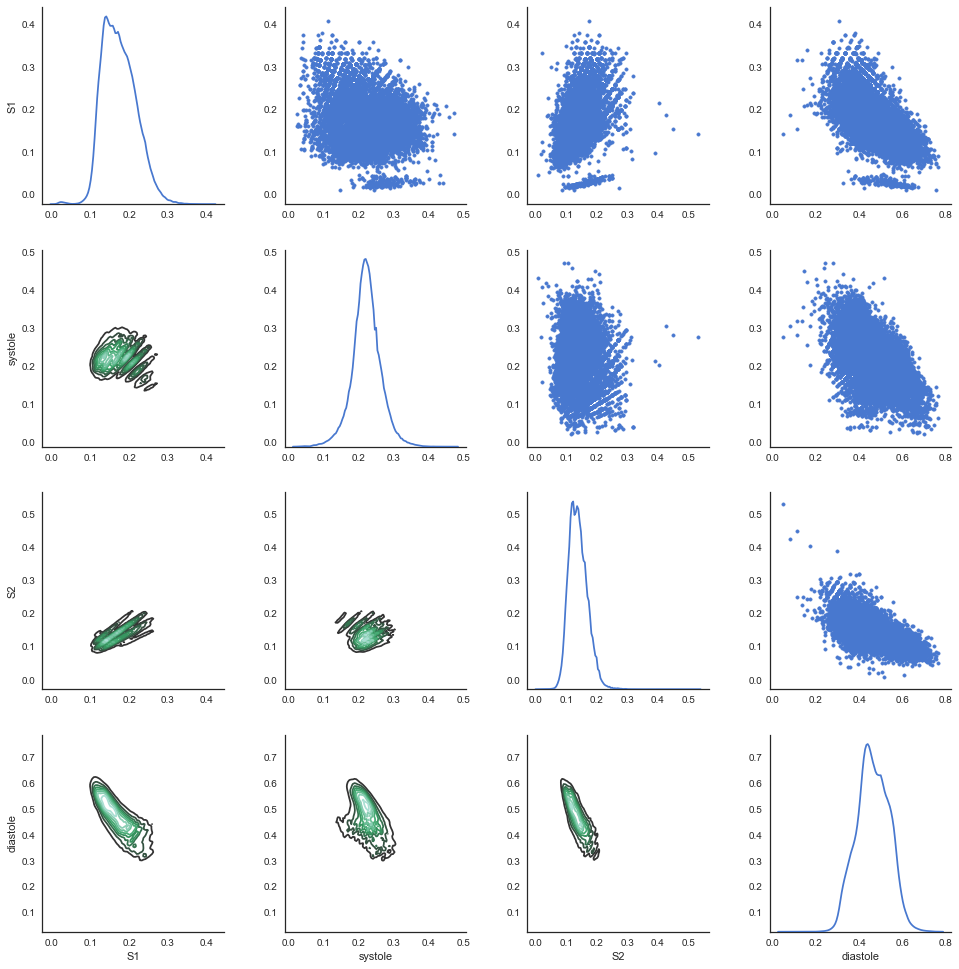

In [19]:
def div_by(column):
    return lambda r: r/r[column]

proportions = heartbeats[METRICS].apply(div_by('cycle'), axis=1)[STAGES]
#proportions#.head()
pairplot(proportions);

/Users/kmamykin/anaconda3/envs/hearts/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


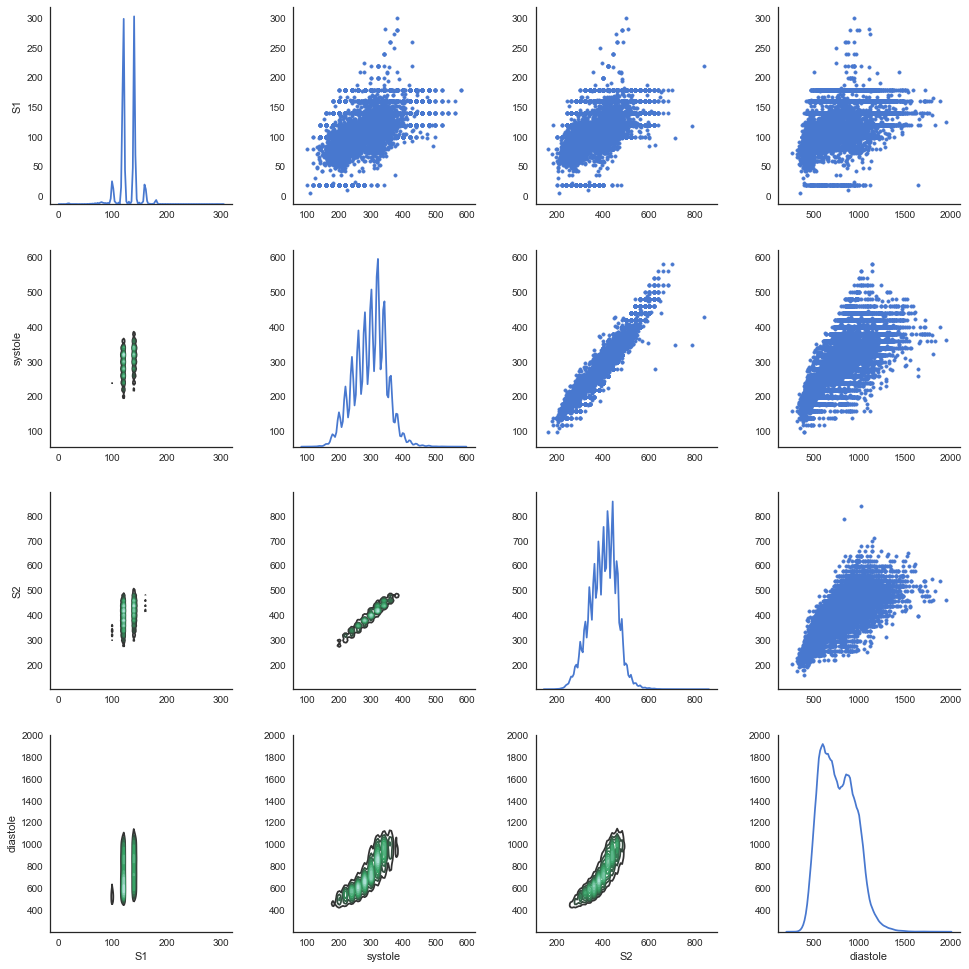

In [50]:
def positions():
    return lambda r: pd.Series({
        'S1': r['S1'],
        'systole': r['S1'] + r['systole'],
        'S2': r['S1'] + r['systole'] + r['S2'],
        'diastole': r['S1'] + r['systole'] + r['S2'] + r['diastole']
    }, index=STAGES)

proportions = heartbeats[METRICS].apply(positions(), axis=1)
#proportions#.head()
pairplot(proportions);